In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [19]:
# Set random seeds for reproducibility
torch.set_num_threads(4) 

data = pd.read_csv('../datasets/meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()


def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  


data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,71.536342


In [20]:
# Select key features
selected_features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'MA for 5 days', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days',
    'EMA for 5 days', 'EMA for 10 days', 'EMA for 20 days', 'EMA for 50 days',
    'RSI_14'
]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[selected_features])

# Create sequences with reduced length
sequence_length = 30  # Reduced from 60
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader with larger batch size
batch_size = 128  # Increased batch size
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class FastStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_projection(x)
        x = self.layer_norm1(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.layer_norm2(x)
        
        # Final prediction
        return self.fc(x)
    
# Initialize the model


In [21]:
from torch.optim.lr_scheduler import StepLR

# 4. Create data loaders
batch_size = 256
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# def train_model_fast(model, train_loader, val_loader, num_epochs=30):
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
#     # Change the scheduler to StepLR
#     scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
#     best_val_loss = float('inf')
#     patience = 5
#     patience_counter = 0
#     training_losses = []
#     validation_losses = []
    
#     for epoch in range(num_epochs):
#         # Training phase
#         model.train()
#         total_train_loss = 0
        
#         for batch_X, batch_y in train_loader:
#             optimizer.zero_grad()
#             outputs = model(batch_X)
#             loss = criterion(outputs.squeeze(), batch_y)
            
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             optimizer.step()
            
#             total_train_loss += loss.item()
        
#         # Step the scheduler at the end of each epoch
#         scheduler.step()
        
#         avg_train_loss = total_train_loss / len(train_loader)
#         training_losses.append(avg_train_loss)
        
#         # Validation phase
#         model.eval()
#         total_val_loss = 0
        
#         with torch.no_grad():
#             for batch_X, batch_y in val_loader:
#                 outputs = model(batch_X)
#                 loss = criterion(outputs.squeeze(), batch_y)
#                 total_val_loss += loss.item()
        
#         avg_val_loss = total_val_loss / len(val_loader)
#         validation_losses.append(avg_val_loss)
        
#         print(f'Epoch [{epoch+1}/{num_epochs}] - '
#               f'Train Loss: {avg_train_loss:.6f} - '
#               f'Val Loss: {avg_val_loss:.6f}')
        
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             torch.save(model.state_dict(), 'best_model.pth')
#             patience_counter = 0
#         else:
#             patience_counter += 1
            
#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break
    
#     return training_losses, validation_losses

class ResponsiveStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing with separate branches for short and long-term patterns
        self.input_projection = nn.Linear(input_dim, d_model)
        self.input_norm = nn.LayerNorm(d_model)
        
        # Short-term branch: Single transformer layer for recent patterns
        self.short_term_encoder = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        # Long-term branch: Multiple transformer layers for trend patterns
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        self.long_term_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # LSTM for sequence modeling
        self.lstm = nn.LSTM(
            input_size=d_model * 2,  # Combined short and long term features
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.output_norm = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_norm(self.input_projection(x))
        
        # Short-term pattern processing
        short_term = self.short_term_encoder(x)
        
        # Long-term pattern processing
        long_term = self.long_term_encoder(x)
        
        # Combine short and long term features
        combined = torch.cat([short_term, long_term], dim=-1)
        
        # Sequence modeling
        lstm_out, _ = self.lstm(combined)
        
        # Take the last timestep and predict
        x = lstm_out[:, -1, :]
        x = self.output_norm(x)
        x = self.fc(x)
        
        return x

def train_responsive_model(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.HuberLoss(delta=0.5)  # More sensitive to small errors
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.002,  # Slightly higher learning rate
        weight_decay=0.005  # Reduced weight decay
    )
    
    # Cyclical learning rate for better exploration
    scheduler = torch.optim.lr_scheduler.CyclicLR(
        optimizer,
        base_lr=0.0001,
        max_lr=0.002,
        step_size_up=4,
        mode='triangular2',
        cycle_momentum=False
    )
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.6f} - '
              f'Val Loss: {avg_val_loss:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    
    return training_losses, validation_losses

# Usage
input_dim = len(selected_features)
model = ResponsiveStockPredictor(input_dim=input_dim)
training_losses, validation_losses = train_responsive_model(model, train_loader, val_loader)

# 3. Initialize model and train
# input_dim = len(selected_features)
# model = FastStockPredictor(input_dim=input_dim)


# 5. Train the model
# training_losses, validation_losses = train_model_fast(model, train_loader, val_loader)





Epoch [1/30] - Train Loss: 0.067273 - Val Loss: 0.009112
Epoch [2/30] - Train Loss: 0.013156 - Val Loss: 0.038228
Epoch [3/30] - Train Loss: 0.004737 - Val Loss: 0.005573
Epoch [4/30] - Train Loss: 0.002846 - Val Loss: 0.006706
Epoch [5/30] - Train Loss: 0.001345 - Val Loss: 0.008523
Epoch [6/30] - Train Loss: 0.001292 - Val Loss: 0.009081
Epoch [7/30] - Train Loss: 0.001004 - Val Loss: 0.005926
Epoch [8/30] - Train Loss: 0.000945 - Val Loss: 0.005028
Epoch [9/30] - Train Loss: 0.000860 - Val Loss: 0.004827
Epoch [10/30] - Train Loss: 0.000851 - Val Loss: 0.004500
Epoch [11/30] - Train Loss: 0.000682 - Val Loss: 0.003994
Epoch [12/30] - Train Loss: 0.000703 - Val Loss: 0.003150
Epoch [13/30] - Train Loss: 0.000605 - Val Loss: 0.002809
Epoch [14/30] - Train Loss: 0.000603 - Val Loss: 0.002640
Epoch [15/30] - Train Loss: 0.000555 - Val Loss: 0.002234
Epoch [16/30] - Train Loss: 0.000516 - Val Loss: 0.002150
Epoch [17/30] - Train Loss: 0.000535 - Val Loss: 0.002244
Epoch [18/30] - Train L

In [22]:
# Make predictions
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_X, _ in val_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]

# Get actual values
actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]




Performance Metrics:
MSE: 349.311
RMSE: 18.690
MAE: 14.237
R2 Score: 0.950


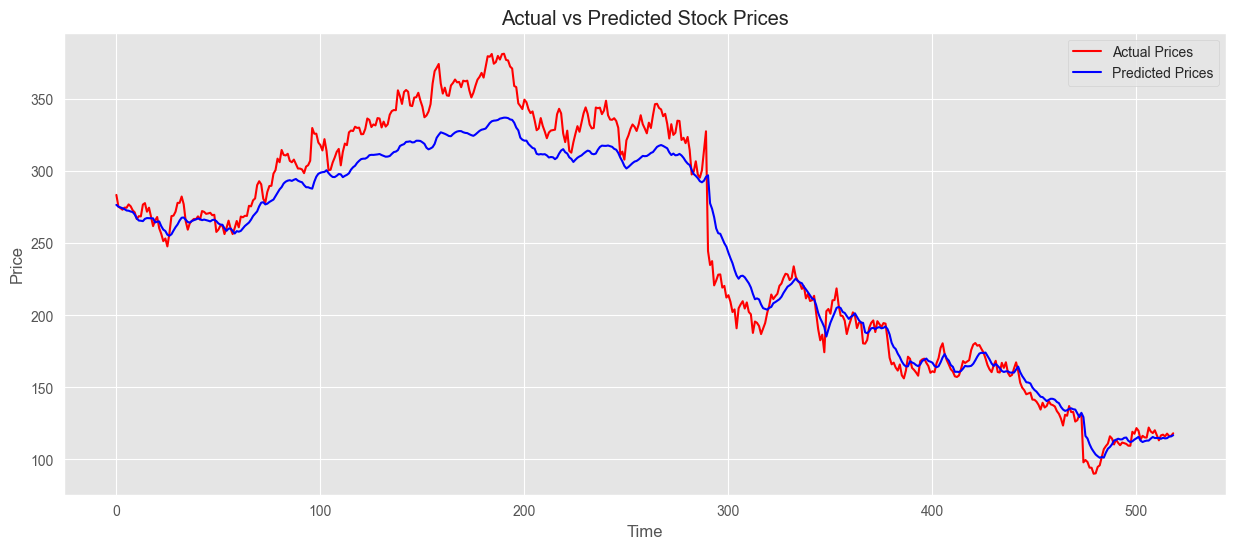

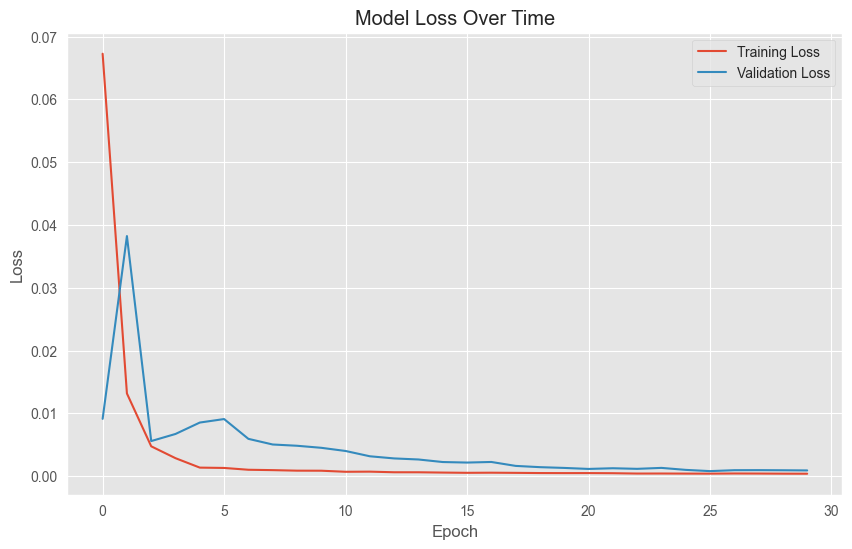

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error

# Permutation Feature Importance
def permutation_feature_importance(model, X_val, y_val, feature_names):
    baseline_score = mean_squared_error(y_val, model(X_val).squeeze().detach().numpy())
    importance_scores = {}

    for i, feature in enumerate(feature_names):
        X_val_perturbed = X_val.clone()
        X_val_perturbed[:, :, i] = X_val_perturbed[:, :, i][torch.randperm(X_val_perturbed.size(0))]
        
        perturbed_score = mean_squared_error(y_val, model(X_val_perturbed).squeeze().detach().numpy())
        importance_scores[feature] = baseline_score - perturbed_score  # Higher drop = more important

    # Normalize importance scores
    total_importance = sum(importance_scores.values())
    for feature in importance_scores:
        importance_scores[feature] /= total_importance

    return importance_scores

# Example usage
feature_names = selected_features  # List of feature names
importance_scores = permutation_feature_importance(model, X_val, y_val, feature_names)
print("Feature Importance Scores:", importance_scores)

# Most Important Features:
# EMA for 5 days (0.239)
# Open (0.213)
# MA for 5 days (0.134)
# MA for 10 days (0.134)
# Low (0.080)

# Less Important Features:
# Volume (-0.0006)
# MA for 20 days (-0.009)
# EMA for 50 days (-0.0003)

# Moderately Important Features:
# High (0.038)
# RSI_14 (0.039)
# EMA for 10 days (0.032)
# EMA for 20 days (0.041)
# MA for 50 days (0.051)

# Most important features:
# selected_features = [
#     'close',
#     'Open',
#     'Low',
#     'EMA for 5 days',
#     'MA for 5 days',
#     'MA for 10 days',
#     'High',
#     'RSI_14'
# ]

Feature Importance Scores: {'Open': -0.0023701120173351318, 'High': 0.016488788889714324, 'Low': 0.14586872582576307, 'Close': 0.22439609609078168, 'Volume': -0.0013395325048642464, 'MA for 5 days': 0.19770637906750102, 'MA for 10 days': 0.19219943458258562, 'MA for 20 days': 0.009687945338738393, 'MA for 50 days': -0.00038088185732546877, 'EMA for 5 days': 0.011096433791154554, 'EMA for 10 days': 0.13915813757370188, 'EMA for 20 days': 0.0020747366589503632, 'EMA for 50 days': 0.03265036579163218, 'RSI_14': 0.032763482769001775}


In [8]:
# Save the model
torch.save(model.state_dict(), 'stock_predictor_model.pth')